# < 3주차 과제 1 : MLP 마음대로 다뤄보기>
- dataset을 임의로 선정해서 직접 분석 해보기(제공한 코드를 활용해서 해보기)
- activation functions 중 relu사용시 함수 직접 정의
- lr, optimizer 등 바꿔보기
- hidden layer/neuron 수를 바꾸기
- 전처리도 추가
- 모든 시도를 올려주세요!
- 제일 높은 acc를 보인 시도를 명시해주세요!


In [2]:
import torch
from torch import nn, optim
from sklearn.datasets import load_breast_cancer
from sklearn.datasets import load_wine
from torch.utils.data import  TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

## 아래 데이터셋 중 원하는 데이터셋 하나를 선택하여, 코드 과제 진행하기!
- 1) load_digits() <br>
- 2) load_wine()

In [3]:
# 데이터셋 종류 : 
data = load_wine()

In [4]:
input = data.data
output = data.target

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

torch.manual_seed(777)
if device == "cuda":
  torch.cuda.manual_seed_all(777)

In [55]:
x_train, x_test, y_train, y_test = train_test_split(input, output, test_size = 0.3, random_state = 42, stratify= data.target, shuffle = True)

x_train = torch.FloatTensor(x_train).to(device)
y_train = torch.LongTensor(y_train).to(device)
x_test = torch.FloatTensor(x_test)
y_test = torch.LongTensor(y_test)

# 데이터를 tensor로 바꿔주고 gpu 연산이 가능해지도록 gpu에 옮김
# label 값을 왜 long 에 옮겨놓는가? loss function이 다르기 때문 

In [33]:
print(x_train[0])
print(y_train[0])

# input 13개 (속성이 13개)
# y의 class는 3개

tensor([1.3750e+01, 1.7300e+00, 2.4100e+00, 1.6000e+01, 8.9000e+01, 2.6000e+00,
        2.7600e+00, 2.9000e-01, 1.8100e+00, 5.6000e+00, 1.1500e+00, 2.9000e+00,
        1.3200e+03])
tensor(0)


In [34]:
print(x_train.shape)
print(y_train.shape)

torch.Size([124, 13])
torch.Size([124])


파이토치에서는 데이터셋을 좀 더 쉽게 다룰 수 있도록 유용한 도구로서 torch.utils.data.Dataset과 torch.utils.data.DataLoader를 제공합니다. 이를 사용하면 미니 배치 학습, 데이터 셔플(shuffle), 병렬 처리까지 간단히 수행할 수 있습니다. 기본적인 사용 방법은 Dataset을 정의하고, 이를 DataLoader에 전달하는 것
- init : class 에서 객체가 생성되면 바로 실행되는 함수
- len : observation 수를 정의하는 함수
- getitem : iteration 마다 해당하는 데이터를 돌려주는 함수

In [19]:
from torch.utils.data import Dataset
class CustomDataset(Dataset):
  def __init__(self):
    self.x_data = x_train
    self.y_data = [[y] for y in y_train] # 정답
    # 데이터셋의 전처리를 해주는 부분

  def __len__(self):
    return len(self.x_data)
    # 데이터셋의 길이. 즉, 총 샘플의 수를 적어주는 부분

  def __getitem__(self, idx):
    x = torch.FloatTensor(self.x_data[idx]).to(device)
    y = torch.LongTensor(self.y_data[idx]).to(device)
    # 데이터셋에서 특정 1개의 샘플을 가져오는 함수

    return x,y

In [56]:
batch_size = 8

dataset = CustomDataset()
dataloader = DataLoader(dataset, batch_size=batch_size) 

In [21]:
# input_layer와 hidden_layer의 노드 개수를 어떻게 바꿔줘야할까? 
# hidden layer/neuron 수를 바꾸기

model = nn.Sequential(
          nn.Linear(13,398, bias=True), 
          nn.Sigmoid(),
          nn.Linear(398,15, bias=True),
          nn.Sigmoid(),
          nn.Linear(15,3, bias=True), 
          nn.Softmax(dim = 1)
          ).to(device)

# 한 번에 output으로 줄이는 것이 아니라 hidden layer 추가

In [22]:
print(model)

Sequential(
  (0): Linear(in_features=13, out_features=398, bias=True)
  (1): Sigmoid()
  (2): Linear(in_features=398, out_features=15, bias=True)
  (3): Sigmoid()
  (4): Linear(in_features=15, out_features=3, bias=True)
  (5): Softmax(dim=1)
)


class로 구현 가능
- init : 초기 생성 함수
- foward : 순전파(입력값 => 예측값 의 과정)

In [23]:
class Model(torch.nn.Module):

  def __init__(self):
    super(Model, self).__init__()
    self.layer1 = nn.Sequential(
          nn.Linear(13,398, bias=True), # input_layer = 13, hidden_layer1 = 398 
          nn.Sigmoid(),
        nn.BatchNorm1d(398)
    )
  # activation function 이용 
  #   nn.ReLU()
  #   nn.tanH()
  #   https://pytorch.org/docs/stable/nn.html 그 외에도 여기서 확인 가능함 
  #   파라미터가 필요하지 않다는 것이 특징

  # batch normazliation 1d, 파라미터 값으로 vector의 길이를 전해줌
  # 추후에 이미지를 다루게 된다면, 그때는 batch normalization 2d를 이용하게 됨 
  # 그때는 파라미터 값으로 채널, 가로, 세로 길이를 전달해주게 됨 

    self.layer2 = nn.Sequential(
          nn.Linear(398,15, bias=True), # hidden_layer1 = 398, hidden_layer2 = 15
        nn.Sigmoid()
    )
    self.layer3 = nn.Sequential(
          nn.Linear(15,10, bias=True), # hidden_layer1 = 15, hidden_layer2 = 10
        nn.Sigmoid()
    )
    self.layer4 = nn.Sequential(
        nn.Linear(10, 3, bias=True), # hidden_layer3 = 10, output_layer = 3
        nn.Softmax(dim = 1)
        # dim = 1 보통 classification에 쓰임
        # 각 sample 마다 softmax 함수
    )

  def forward(self,x):
    output = self.layer1(x)
    output = self.layer2(output)
    output = self.layer3(output)
    output = self.layer4(output)
    return output

In [24]:
def init_weights(layer):
    if isinstance(layer, nn.Linear):
        torch.nn.init.xavier_uniform(layer.weight)
        layer.bias.data.fill_(0.01)

        # xavier사용
        # Layer의 weight를 어떤 분포를 가지도록 초기화시켜줌 + global minimum찾기 위해서

In [51]:
model = Model().to(device)
model.apply(init_weights)

/var/folders/1w/94w03vcn7rv_gpwvy1gmzjhw0000gn/T/ipykernel_51434/3402539847.py:3: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(layer.weight)


Model(
  (layer1): Sequential(
    (0): Linear(in_features=13, out_features=398, bias=True)
    (1): Sigmoid()
    (2): BatchNorm1d(398, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (layer2): Sequential(
    (0): Linear(in_features=398, out_features=15, bias=True)
    (1): Sigmoid()
  )
  (layer3): Sequential(
    (0): Linear(in_features=15, out_features=10, bias=True)
    (1): Sigmoid()
  )
  (layer4): Sequential(
    (0): Linear(in_features=10, out_features=3, bias=True)
    (1): Softmax(dim=1)
  )
)

In [37]:
print(model)

Model(
  (layer1): Sequential(
    (0): Linear(in_features=13, out_features=398, bias=True)
    (1): Sigmoid()
    (2): BatchNorm1d(398, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (layer2): Sequential(
    (0): Linear(in_features=398, out_features=15, bias=True)
    (1): Sigmoid()
  )
  (layer3): Sequential(
    (0): Linear(in_features=15, out_features=10, bias=True)
    (1): Sigmoid()
  )
  (layer4): Sequential(
    (0): Linear(in_features=10, out_features=3, bias=True)
    (1): Softmax(dim=1)
  )
)


In [52]:
loss_fn  = nn.CrossEntropyLoss().to(device)

# https://pytorch.org/docs/stable/optim.html#module-torch.optim 페이지 참조

In [28]:
# Adam Optimizer, lr = 0.01 -> 큰 학습율

optimizer_adam = optim.Adam(model.parameters(), lr= 0.01)

losses = []
for epoch in range(100):

  optimizer_adam.zero_grad()
  hypothesis = model(x_train) # 예측값

  # 비용 함수
  cost = loss_fn(hypothesis, y_train)
  cost.backward()
  optimizer_adam.step()
  losses.append(cost.item())

  # 마지막 10개의 loss 출력
  if epoch % 10 == 0:
    print(epoch, cost.item())

0 1.0932259559631348
10 0.9515987634658813
20 0.8548331260681152
30 0.7939021587371826
40 0.7404029965400696
50 0.6667525172233582
60 0.6203221678733826
70 0.5986315608024597
80 0.5750282406806946
90 0.610567569732666


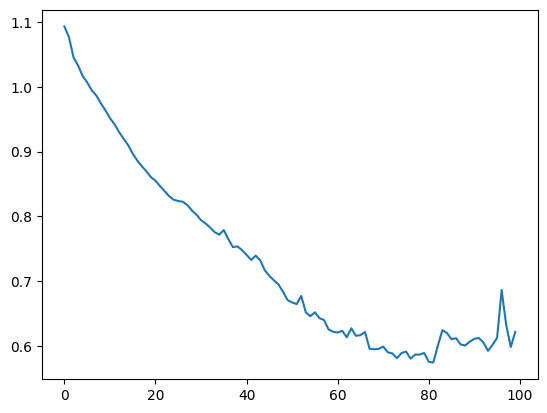

In [29]:
plt.plot(losses)
plt.show()

In [30]:
with torch.no_grad():
  model = model.to('cpu') # move a PyTorch model to the CPU
  y_pred = model(x_test) # 예측값
  y_pred = y_pred.detach().numpy() # numpy 형식
  predicted = np.argmax(y_pred, axis =1)
  accuracy = (accuracy_score(predicted, y_test))

In [31]:
print(f'model의 output은 :  {y_pred[0]}')
print(f'argmax를 한 후의 output은 {predicted[0]}')
print(f'accuracy는 {accuracy}')

model의 output은 :  [0.9755086  0.02275743 0.00173402]
argmax를 한 후의 output은 0
accuracy는 0.9259259259259259


0 1.167346477508545
10 1.1322615146636963
20 1.1051421165466309
30 1.0777397155761719
40 1.0509898662567139
50 1.0239697694778442
60 0.9992327690124512
70 0.9766460657119751
80 0.9553103446960449
90 0.9337450265884399


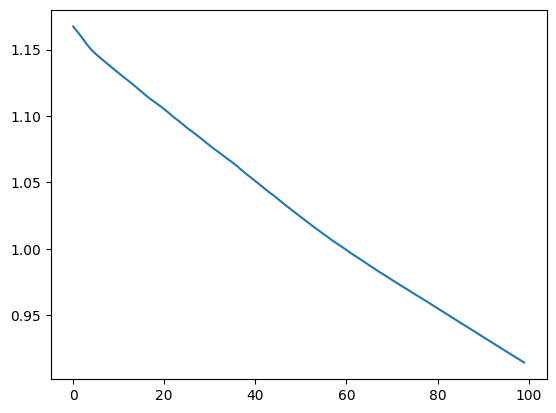

In [39]:
# Adam Optimizer, lr = 0.001 -> 작은 학습율

optimizer_adam_s = optim.Adam(model.parameters(), lr= 0.001)

losses_adam_s = []
for epoch in range(100):

  optimizer_adam_s.zero_grad()
  hypothesis = model(x_train) # 예측값

  # 비용 함수
  cost = loss_fn(hypothesis, y_train)
  cost.backward()
  optimizer_adam_s.step()
  losses_adam_s.append(cost.item())

  # 마지막 10개의 loss 출력
  if epoch % 10 == 0:
    print(epoch, cost.item())
    
plt.plot(losses_adam_s)
plt.show()

In [40]:
with torch.no_grad():
  model = model.to('cpu') # move a PyTorch model to the CPU
  y_pred = model(x_test) # 예측값
  y_pred = y_pred.detach().numpy() # numpy 형식
  predicted = np.argmax(y_pred, axis =1)
  accuracy = (accuracy_score(predicted, y_test))

print(f'model의 output은 :  {y_pred[0]}')
print(f'argmax를 한 후의 output은 {predicted[0]}')
print(f'accuracy는 {accuracy}')

model의 output은 :  [0.61855567 0.13213283 0.24931154]
argmax를 한 후의 output은 0
accuracy는 0.9629629629629629


0 1.131546974182129
10 1.0945905447006226
20 1.0650978088378906
30 1.0450592041015625
40 1.0699470043182373
50 1.0868010520935059
60 1.0827842950820923
70 1.0846446752548218
80 1.0840117931365967
90 1.0842244625091553


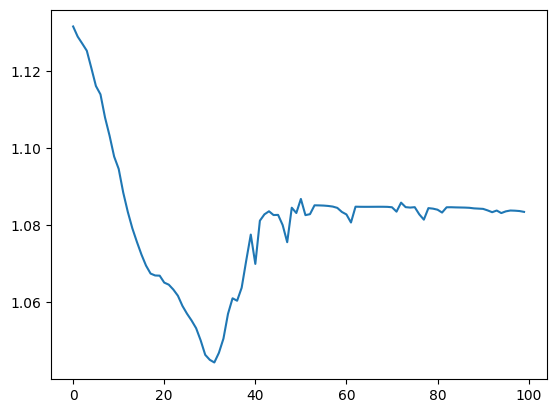

In [45]:
# SDG Optimizer, lr = 0.1 -> 큰 학습율

optimizer_sdg = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)

losses_sdg = []
for epoch in range(100):

  optimizer_sdg.zero_grad()
  hypothesis = model(x_train) # 예측값

  # 비용 함수
  cost = loss_fn(hypothesis, y_train)
  cost.backward()
  optimizer_sdg.step()
  losses_sdg.append(cost.item())

  # 마지막 10개의 loss 출력
  if epoch % 10 == 0:
    print(epoch, cost.item())
    
plt.plot(losses_sdg)
plt.show()

In [46]:
with torch.no_grad():
  model = model.to('cpu') # move a PyTorch model to the CPU
  y_pred = model(x_test) # 예측값
  y_pred = y_pred.detach().numpy() # numpy 형식
  predicted = np.argmax(y_pred, axis =1)
  accuracy = (accuracy_score(predicted, y_test))

print(f'model의 output은 :  {y_pred[0]}')
print(f'argmax를 한 후의 output은 {predicted[0]}')
print(f'accuracy는 {accuracy}')

model의 output은 :  [0.3541377  0.53848636 0.10737588]
argmax를 한 후의 output은 1
accuracy는 0.3888888888888889


0 1.107074499130249
10 1.0980359315872192
20 1.0939496755599976
30 1.0885504484176636
40 1.0835999250411987
50 1.0795440673828125
60 1.075195074081421
70 1.0711445808410645
80 1.067637324333191
90 1.0633234977722168


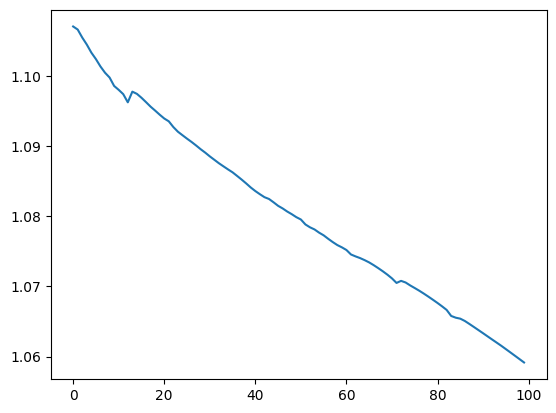

In [53]:
# SDG Optimizer, lr = 0.01 -> 작은 학습율

optimizer_sdg_s = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

losses_sdg_s = []
for epoch in range(100):

  optimizer_sdg_s.zero_grad()
  hypothesis = model(x_train) # 예측값

  # 비용 함수
  cost = loss_fn(hypothesis, y_train)
  cost.backward()
  optimizer_sdg_s.step()
  losses_sdg_s.append(cost.item())

  # 마지막 10개의 loss 출력
  if epoch % 10 == 0:
    print(epoch, cost.item())
    
plt.plot(losses_sdg_s)
plt.show()

In [54]:
with torch.no_grad():
  model = model.to('cpu') # move a PyTorch model to the CPU
  y_pred = model(x_test) # 예측값
  y_pred = y_pred.detach().numpy() # numpy 형식
  predicted = np.argmax(y_pred, axis =1)
  accuracy = (accuracy_score(predicted, y_test))

print(f'model의 output은 :  {y_pred[0]}')
print(f'argmax를 한 후의 output은 {predicted[0]}')
print(f'accuracy는 {accuracy}')

model의 output은 :  [0.20995088 0.50331974 0.28672928]
argmax를 한 후의 output은 1
accuracy는 0.3888888888888889


In [57]:
# Using nn.ReLU() as an activation function
# nn.ReLU() : 범위는 (0, +∞), 매우 효과적이고 계산이 빠른 활성화 함수로, 은닉층에서 주로 사용

class Model(torch.nn.Module):

  def __init__(self):
    super(Model, self).__init__()
    self.layer1 = nn.Sequential(
          nn.Linear(13,398, bias=True), # input_layer = 13, hidden_layer1 = 398 
          nn.ReLU(),
        nn.BatchNorm1d(398)
    )

    # batch normazliation 1d, 파라미터 값으로 vector의 길이를 전해줌
    # 추후에 이미지를 다루게 된다면, 그때는 batch normalization 2d를 이용하게 됨 
    # 그때는 파라미터 값으로 채널, 가로, 세로 길이를 전달해주게 됨 

    self.layer2 = nn.Sequential(
          nn.Linear(398,15, bias=True), # hidden_layer1 = 398, hidden_layer2 = 15
        nn.ReLU(),
    )
    self.layer3 = nn.Sequential(
          nn.Linear(15,10, bias=True), # hidden_layer1 = 15, hidden_layer2 = 10
        nn.ReLU(),
    )
    self.layer4 = nn.Sequential(
        nn.Linear(10, 3, bias=True), # hidden_layer3 = 10, output_layer = 3
        nn.Softmax(dim = 1) # 그래도 마지막에 Softmax함수를 쓰는 이유는 output이 이진분류이기 때문
                            # Softmax 함수는 출력 범위가 (0,1)로 모델 출력을 확률로 해석 가능
    )

  def forward(self,x):
    output = self.layer1(x)
    output = self.layer2(output)
    output = self.layer3(output)
    output = self.layer4(output)
    return output

In [58]:
model = Model().to(device)
model.apply(init_weights)

print(model)

Model(
  (layer1): Sequential(
    (0): Linear(in_features=13, out_features=398, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(398, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (layer2): Sequential(
    (0): Linear(in_features=398, out_features=15, bias=True)
    (1): ReLU()
  )
  (layer3): Sequential(
    (0): Linear(in_features=15, out_features=10, bias=True)
    (1): ReLU()
  )
  (layer4): Sequential(
    (0): Linear(in_features=10, out_features=3, bias=True)
    (1): Softmax(dim=1)
  )
)


/var/folders/1w/94w03vcn7rv_gpwvy1gmzjhw0000gn/T/ipykernel_51434/3402539847.py:3: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(layer.weight)


0 1.1483900547027588
10 0.7496241331100464
20 0.6189386248588562
30 0.5982171297073364
40 0.5921940803527832
50 0.5905695557594299
60 0.5861404538154602
70 0.5728455781936646
80 0.5735688805580139
90 0.5681279301643372


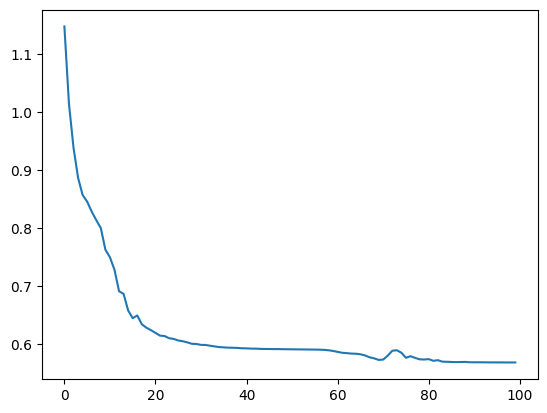

In [59]:
loss_fn  = nn.CrossEntropyLoss().to(device)

# Adam Optimizer, lr = 0.01 -> 큰 학습율

optimizer_adam = optim.Adam(model.parameters(), lr= 0.01)

losses = []
for epoch in range(100):

  optimizer_adam.zero_grad()
  hypothesis = model(x_train) # 예측값

  # 비용 함수
  cost = loss_fn(hypothesis, y_train)
  cost.backward()
  optimizer_adam.step()
  losses.append(cost.item())

  # 마지막 10개의 loss 출력
  if epoch % 10 == 0:
    print(epoch, cost.item())

plt.plot(losses)
plt.show()

In [60]:
with torch.no_grad():
  model = model.to('cpu') # move a PyTorch model to the CPU
  y_pred = model(x_test) # 예측값
  y_pred = y_pred.detach().numpy() # numpy 형식
  predicted = np.argmax(y_pred, axis =1)
  accuracy = (accuracy_score(predicted, y_test))

print(f'model의 output은 :  {y_pred[0]}')
print(f'argmax를 한 후의 output은 {predicted[0]}')
print(f'accuracy는 {accuracy}')

model의 output은 :  [9.9997818e-01 7.8783222e-07 2.1012656e-05]
argmax를 한 후의 output은 0
accuracy는 0.9629629629629629


# < 3주차 과제 2 : CNN 맛보기>

In [59]:
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable

In [60]:
# Training settings

batch_size = 64

# MNIST Dataset
train_dataset = datasets.MNIST(root='./data/',
                               train=True,
                               transform=transforms.ToTensor(),
                               download=True)

test_dataset = datasets.MNIST(root='./data/',
                              train=False,
                              transform=transforms.ToTensor())

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)

100%|████████████████████████████| 9912422/9912422 [00:01<00:00, 4964917.32it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|███████████████████████████████| 28881/28881 [00:00<00:00, 11735680.47it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|████████████████████████████| 1648877/1648877 [00:00<00:00, 9390658.61it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████████████████████████████| 4542/4542 [00:00<00:00, 1844908.85it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [61]:
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.conv1 = nn.Conv2d(1, 10, kernel_size = 5)
    self.conv2 = nn.Conv2d(10, 20, kernel_size = 5)
    self.mp = nn.MaxPool2d(2)
    self.fc = nn.Linear(20 * 4 * 4, 10) 
    # Assuming the spatial dimensions after the second max pooling are 4x4
    # Default padding 0, stride 1


  def forward(self, x):
    in_size = x.size(0)
    x = F.relu(self.mp(self.conv1(x)))
    x = F.relu(self.mp(self.conv2(x)))
    x = x.view(in_size, -1)
    x = self.fc(x)
    return F.log_softmax(x)

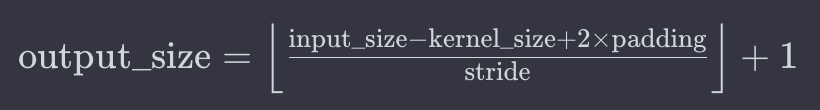

In [62]:
model = Net()
optimizer = optim.SGD(model.parameters(), lr = 0.01, momentum = 0.5)

In [63]:
def train(epoch):
  model.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    data, target = Variable(data), Variable(target)
    optimizer.zero_grad()
    output = model(data)
    loss = F.nll_loss(output, target)
    loss.backward()
    optimizer.step()
    if batch_idx % 10 == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
          epoch, batch_idx * len(data), len(train_loader.dataset),
          100. * batch_idx / len(train_loader), loss.item()))

In [64]:
def test():
    model.eval() 
    # model.eval() 의 기능은?
    # PyTorch 모델을 평가 모드로 설정하는 메서드
    # 모델을 평가 모드로 설정하면 모델 내부의 일부 층들이 학습 중에 사용되는 
    # 드롭아웃(dropout)이나 배치 정규화(batch normalization)와 같은 특정 동작을 평가 모드에 맞게 조정
    
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        data, target = Variable(data, volatile=True), Variable(target)
        output = model(data)
        test_loss += F.nll_loss(output, target, size_average=False).data # nll_loss?? / cross entropy loss와의 관계 확인!
        pred = output.data.max(1, keepdim=True)[1]
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [65]:
for epoch in range(1, 10):
    train(epoch)
    test()

/var/folders/1w/94w03vcn7rv_gpwvy1gmzjhw0000gn/T/ipykernel_50550/3450331345.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.301644
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.314152
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.292846
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.283323
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.284157
Train Epoch: 1 [3200/60000 (5%)]	Loss: 2.277850
Train Epoch: 1 [3840/60000 (6%)]	Loss: 2.261839
Train Epoch: 1 [4480/60000 (7%)]	Loss: 2.249530
Train Epoch: 1 [5120/60000 (9%)]	Loss: 2.244027
Train Epoch: 1 [5760/60000 (10%)]	Loss: 2.230111
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.195687
Train Epoch: 1 [7040/60000 (12%)]	Loss: 2.169042
Train Epoch: 1 [7680/60000 (13%)]	Loss: 2.131698
Train Epoch: 1 [8320/60000 (14%)]	Loss: 2.025305
Train Epoch: 1 [8960/60000 (15%)]	Loss: 1.959995
Train Epoch: 1 [9600/60000 (16%)]	Loss: 1.814789
Train Epoch: 1 [10240/60000 (17%)]	Loss: 1.558455
Train Epoch: 1 [10880/60000 (18%)]	Loss: 1.359700
Train Epoch: 1 [11520/60000 (19%)]	Loss: 1.049719
Train Epoch: 1 [12160/60000 (20%)]	Loss: 0.998806
Train Epoch: 1 [12800/60000 (

/var/folders/1w/94w03vcn7rv_gpwvy1gmzjhw0000gn/T/ipykernel_50550/2324877592.py:6: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data, target = Variable(data, volatile=True), Variable(target)
/opt/anaconda3/lib/python3.9/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Average loss: 0.1987, Accuracy: 9419/10000 (94%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.129440
Train Epoch: 2 [640/60000 (1%)]	Loss: 0.326835
Train Epoch: 2 [1280/60000 (2%)]	Loss: 0.250106
Train Epoch: 2 [1920/60000 (3%)]	Loss: 0.129902
Train Epoch: 2 [2560/60000 (4%)]	Loss: 0.120616
Train Epoch: 2 [3200/60000 (5%)]	Loss: 0.241876
Train Epoch: 2 [3840/60000 (6%)]	Loss: 0.120047
Train Epoch: 2 [4480/60000 (7%)]	Loss: 0.304248
Train Epoch: 2 [5120/60000 (9%)]	Loss: 0.209310
Train Epoch: 2 [5760/60000 (10%)]	Loss: 0.259439
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.250681
Train Epoch: 2 [7040/60000 (12%)]	Loss: 0.233188
Train Epoch: 2 [7680/60000 (13%)]	Loss: 0.121874
Train Epoch: 2 [8320/60000 (14%)]	Loss: 0.182673
Train Epoch: 2 [8960/60000 (15%)]	Loss: 0.147631
Train Epoch: 2 [9600/60000 (16%)]	Loss: 0.127460
Train Epoch: 2 [10240/60000 (17%)]	Loss: 0.242004
Train Epoch: 2 [10880/60000 (18%)]	Loss: 0.097707
Train Epoch: 2 [11520/60000 (19%)]	Loss: 0.178627
Train Epoch: 2 [12

Train Epoch: 3 [44160/60000 (74%)]	Loss: 0.040933
Train Epoch: 3 [44800/60000 (75%)]	Loss: 0.112658
Train Epoch: 3 [45440/60000 (76%)]	Loss: 0.236489
Train Epoch: 3 [46080/60000 (77%)]	Loss: 0.140244
Train Epoch: 3 [46720/60000 (78%)]	Loss: 0.105092
Train Epoch: 3 [47360/60000 (79%)]	Loss: 0.052786
Train Epoch: 3 [48000/60000 (80%)]	Loss: 0.131564
Train Epoch: 3 [48640/60000 (81%)]	Loss: 0.253395
Train Epoch: 3 [49280/60000 (82%)]	Loss: 0.060012
Train Epoch: 3 [49920/60000 (83%)]	Loss: 0.043195
Train Epoch: 3 [50560/60000 (84%)]	Loss: 0.116907
Train Epoch: 3 [51200/60000 (85%)]	Loss: 0.095486
Train Epoch: 3 [51840/60000 (86%)]	Loss: 0.098915
Train Epoch: 3 [52480/60000 (87%)]	Loss: 0.121493
Train Epoch: 3 [53120/60000 (88%)]	Loss: 0.117559
Train Epoch: 3 [53760/60000 (90%)]	Loss: 0.071881
Train Epoch: 3 [54400/60000 (91%)]	Loss: 0.135397
Train Epoch: 3 [55040/60000 (92%)]	Loss: 0.123207
Train Epoch: 3 [55680/60000 (93%)]	Loss: 0.102790
Train Epoch: 3 [56320/60000 (94%)]	Loss: 0.054161


Train Epoch: 5 [28800/60000 (48%)]	Loss: 0.238998
Train Epoch: 5 [29440/60000 (49%)]	Loss: 0.030756
Train Epoch: 5 [30080/60000 (50%)]	Loss: 0.093468
Train Epoch: 5 [30720/60000 (51%)]	Loss: 0.018541
Train Epoch: 5 [31360/60000 (52%)]	Loss: 0.084840
Train Epoch: 5 [32000/60000 (53%)]	Loss: 0.106691
Train Epoch: 5 [32640/60000 (54%)]	Loss: 0.074824
Train Epoch: 5 [33280/60000 (55%)]	Loss: 0.082403
Train Epoch: 5 [33920/60000 (57%)]	Loss: 0.031333
Train Epoch: 5 [34560/60000 (58%)]	Loss: 0.021207
Train Epoch: 5 [35200/60000 (59%)]	Loss: 0.209203
Train Epoch: 5 [35840/60000 (60%)]	Loss: 0.093194
Train Epoch: 5 [36480/60000 (61%)]	Loss: 0.098152
Train Epoch: 5 [37120/60000 (62%)]	Loss: 0.128899
Train Epoch: 5 [37760/60000 (63%)]	Loss: 0.016358
Train Epoch: 5 [38400/60000 (64%)]	Loss: 0.037436
Train Epoch: 5 [39040/60000 (65%)]	Loss: 0.081590
Train Epoch: 5 [39680/60000 (66%)]	Loss: 0.054320
Train Epoch: 5 [40320/60000 (67%)]	Loss: 0.047237
Train Epoch: 5 [40960/60000 (68%)]	Loss: 0.036767


Train Epoch: 7 [12800/60000 (21%)]	Loss: 0.018864
Train Epoch: 7 [13440/60000 (22%)]	Loss: 0.025121
Train Epoch: 7 [14080/60000 (23%)]	Loss: 0.031458
Train Epoch: 7 [14720/60000 (25%)]	Loss: 0.147075
Train Epoch: 7 [15360/60000 (26%)]	Loss: 0.173508
Train Epoch: 7 [16000/60000 (27%)]	Loss: 0.021653
Train Epoch: 7 [16640/60000 (28%)]	Loss: 0.137276
Train Epoch: 7 [17280/60000 (29%)]	Loss: 0.019559
Train Epoch: 7 [17920/60000 (30%)]	Loss: 0.009488
Train Epoch: 7 [18560/60000 (31%)]	Loss: 0.092218
Train Epoch: 7 [19200/60000 (32%)]	Loss: 0.065182
Train Epoch: 7 [19840/60000 (33%)]	Loss: 0.038902
Train Epoch: 7 [20480/60000 (34%)]	Loss: 0.072134
Train Epoch: 7 [21120/60000 (35%)]	Loss: 0.027349
Train Epoch: 7 [21760/60000 (36%)]	Loss: 0.040722
Train Epoch: 7 [22400/60000 (37%)]	Loss: 0.030596
Train Epoch: 7 [23040/60000 (38%)]	Loss: 0.142083
Train Epoch: 7 [23680/60000 (39%)]	Loss: 0.039274
Train Epoch: 7 [24320/60000 (41%)]	Loss: 0.049161
Train Epoch: 7 [24960/60000 (42%)]	Loss: 0.034217


Train Epoch: 8 [58240/60000 (97%)]	Loss: 0.014324
Train Epoch: 8 [58880/60000 (98%)]	Loss: 0.044083
Train Epoch: 8 [59520/60000 (99%)]	Loss: 0.097463

Test set: Average loss: 0.0566, Accuracy: 9830/10000 (98%)

Train Epoch: 9 [0/60000 (0%)]	Loss: 0.110283
Train Epoch: 9 [640/60000 (1%)]	Loss: 0.041107
Train Epoch: 9 [1280/60000 (2%)]	Loss: 0.029374
Train Epoch: 9 [1920/60000 (3%)]	Loss: 0.114733
Train Epoch: 9 [2560/60000 (4%)]	Loss: 0.060480
Train Epoch: 9 [3200/60000 (5%)]	Loss: 0.192293
Train Epoch: 9 [3840/60000 (6%)]	Loss: 0.029661
Train Epoch: 9 [4480/60000 (7%)]	Loss: 0.069208
Train Epoch: 9 [5120/60000 (9%)]	Loss: 0.206947
Train Epoch: 9 [5760/60000 (10%)]	Loss: 0.044904
Train Epoch: 9 [6400/60000 (11%)]	Loss: 0.169393
Train Epoch: 9 [7040/60000 (12%)]	Loss: 0.013829
Train Epoch: 9 [7680/60000 (13%)]	Loss: 0.027804
Train Epoch: 9 [8320/60000 (14%)]	Loss: 0.223909
Train Epoch: 9 [8960/60000 (15%)]	Loss: 0.069183
Train Epoch: 9 [9600/60000 (16%)]	Loss: 0.022075
Train Epoch: 9 [10